In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

import package_DBR
from package_DBR import myRound, FOPDT, FOPDT_cost
import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode
import package_JM_RS 

from package_JM_RS import LL_RT, Margins, PID_RT, IMC_Tuning

In [20]:
# Paramètres de simulation

Tsim = 2200
Ts = 1
N = int(Tsim/Ts) + 1

MV0 = 50
DV0 = 50
PV0 = 65

Kp = 0.5194904467673822
T1p = 129.9860279570493
T2p = 2.2419668343920548e-08
thetap = 7.219217782540495

Kd = 0.5066617883318505
T1d = 198.90601996256459
T2d = 8.124468051389487
thetad = 1.0918143519352412

gamma = 0.5

Kc,Ti,Td = IMC_Tuning(Kp,T1p,T2p,thetap)
alpha = 1



#1 OLP + no FF

# ManPath = {0 : True,Tsim : True}
# MVManPath = {0 : MV0, Tsim : MV0}
# SPPath = {0 : PV0, 800 : PV0}
# DVPath = {0 : 50, 1000 : 60, Tsim : 60}
# ActivateFF = False
# ManFF = True

#2 OLP + FF

# ManPath = {0 : True,Tsim : False}
# MVManPath = {0 : MV0, Tsim : MV0}
# SPPath = {0 : PV0, 800 : PV0}
# DVPath = {0 : 50, 1000 : 60, Tsim : 60}
# ActivateFF = True
# ManFF = True

#3 CLP + no FF

ManPath = {0 : True, 750: False, Tsim : False}
MVManPath = {0 : MV0, Tsim : MV0}
SPPath = {0 : PV0, 800 : PV0-10, Tsim : PV0-10}
DVPath = {0 : DV0, 1500 : DV0+10, Tsim : DV0+10}
ActivateFF = False
ManFF = False

# ManPath = {0 : False, 750: False, Tsim : False}
# MVManPath = {0 : MV0, Tsim : MV0}
# SPPath = {0 : PV0, 800 : PV0-10, Tsim : PV0-10}
# DVPath = {0 : DV0, 1500 : DV0 , Tsim : DV0 }
# ActivateFF = False
# ManFF = False

#4 CLP + FF

# ManPath = {0 : True, 750: False, Tsim : False}
# MVManPath = {0 : MV0, Tsim : MV0}
# SPPath = {0 : PV0, 800 : PV0-10, Tsim : PV0-10}
# DVPath = {0 : DV0, 1500 : DV0+10, Tsim : DV0+10}
# ActivateFF = True
# ManFF = False

In [21]:
t = []
SPt = [] 
MVt = [] 
Mant = []
MVMant = []
MVFF = []
MVPt = []
MVIt = []
MVDt = []
DVt = [] 
PVt = [] 
Et = []

MVFFDelay = []
MVFFLL1 = [] 



MVDelayp = [] 
PV1p = [] 
PV2p = []

MVDelayd = [] 
PV1d = []
PV2d = []
MVMin = 0
MVMax = 500

for i in range(0,N): 
    t.append(i*Ts)
    
    SelectPath_RT(SPPath,t,SPt)
    SelectPath_RT(DVPath,t,DVt)
    
    Delay_RT(DVt - DV0*np.ones_like(DVt),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    LL_RT(MVFFDelay,-Kd/Kp,T1p,T1d,Ts,MVFFLL1)

    if ActivateFF :
        LL_RT(MVFFLL1,1,T2p,T2d,Ts,MVFF)
    else : 
        LL_RT(MVFFLL1,0,T2p,T2d,Ts,MVFF)
    
    SelectPath_RT(ManPath,t,Mant)
    SelectPath_RT(MVManPath,t,MVMant)

    PID_RT(SPt,PVt,Mant,MVMant,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MVt,MVPt,MVIt,MVDt,Et,ManFF,PV0)

    Delay_RT(MVt,thetap,Ts,MVDelayp,MV0)
    FO_RT(MVDelayp,Kp,T1p,Ts,PV1p,0)
    FO_RT(PV1p,1,T2p,Ts,PV2p,0)

    Delay_RT(DVt - DV0*np.ones_like(DVt),thetad,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)

    PVt.append(PV2p[-1] + PV2d[-1] + PV0-Kp*MV0)


(40.0, 70.0)

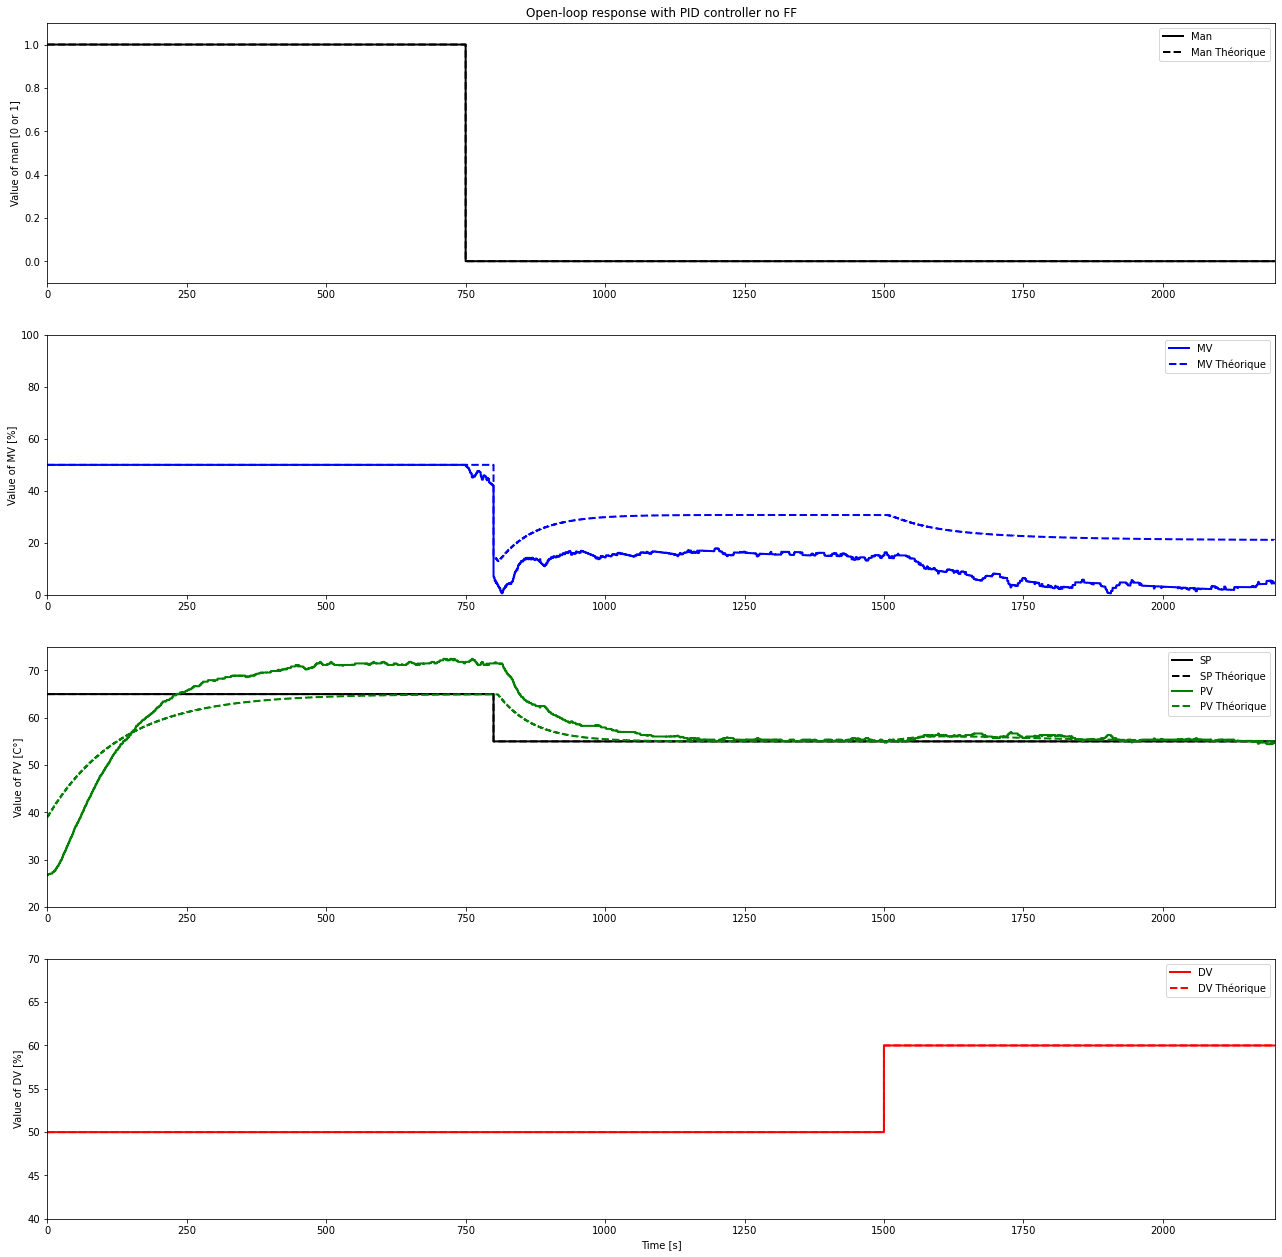

In [22]:
# nameFile = 'Open_loop_experiment_on_DV_2021-06-09-09h39.txt'
nameFile = 'Closed_Loop_experiment_with_PID_No_FF_2022-03-31-16-21.txt'

 
titleName = nameFile.split('.')[0]    
data = pd.read_csv('Data/' + nameFile)
t = data['t'].values - data['t'].values[0]
MV = data['MV'].values
MVP = data['MVP'].values
MVI = data['MVI'].values
MVD = data['MVD'].values
SP = data['SP'].values
PV = data['PV'].values
DV = data['DV'].values
Man = data['Man'].values


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
fig.set_figheight(22)
fig.set_figwidth(22)

l1, = ax1.step([0,t[-1]],[0,100],'k-',linewidth=2,label='Man',where='post')
l6, = ax1.step([0,t[-1]],[0,100],'k--',linewidth=2,label='Man Théorique',where='post')
ax1.set_ylabel('Value of man [0 or 1]')
ax1.set_title('Open-loop response with PID controller no FF')
ax1.legend(loc='best')

l2, = ax2.step([0,t[-1]],[0,100],'b-',linewidth=2,label='MV',where='post')
l7, = ax2.step([0,t[-1]],[0,100],'b--',linewidth=2,label='MV Théorique',where='post')
ax2.set_ylabel('Value of MV [%]')
ax2.legend(loc='best')


l3, = ax3.step([0,t[-1]],[0,100],'k-',linewidth=2,label='SP',where='post')
l8, = ax3.step([0,t[-1]],[0,100],'k--',linewidth=2,label='SP Théorique',where='post')
l4, = ax3.step([0,t[-1]],[0,100],'g-',linewidth=2,label='PV',where='post')
l9, = ax3.step([0,t[-1]],[0,100],'g--',linewidth=2,label='PV Théorique',where='post')
ax3.set_ylabel('Value of PV [C°]')
ax3.legend(loc='best')

l5, = ax4.step([0,t[-1]],[0,100],'r-',linewidth=2,label='DV',where='post')
l10, = ax4.step([0,t[-1]],[0,100],'r--',linewidth=2,label='DV Théorique',where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Value of DV [%]')
ax4.legend(loc='best')

ManInt = [int(x) for x in Man]
ManIntt = [int(x) for x in Mant]
l1.set_data(t,ManInt)
l2.set_data(t,MV)
l3.set_data(t,SP)
l4.set_data(t,PV)
l5.set_data(t,DV)
l6.set_data(t,ManIntt)
l7.set_data(t,MVt)
l8.set_data(t,SPt)
l9.set_data(t,PVt)
l10.set_data(t,DVt)



ax1.set_xlim(0, t[-1]+1)
ax2.set_xlim(0, t[-1]+1)
ax3.set_xlim(0, t[-1]+1)
ax4.set_xlim(0, t[-1]+1)

ax1.set_ylim(-0.1,1.1)
ax2.set_ylim(0,100)
ax3.set_ylim(myRound(np.min((np.min(PV),np.min(SP))),5)-5, myRound(np.max((np.max(PV),np.max(SP))),5)+5)
ax4.set_ylim(40,70)